# Approximating the Diffusion Equation

## Forward Euler

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from euler import solve_diffusion_equation_FE, analytical_solution
from ffnn_pde_solver import PDESolver
from trial_functions import u_trial, u_analytical

2022-12-17 14:08:00.176773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 14:08:00.869772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-17 14:08:00.869894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-17 14:08:00.869900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

First, we will simulate the diffusion equation in 1D using forward Euler. We will use the following parameters:


In [2]:
dx = 0.01 
dt = 0.00001 # Chosen to satisfy the stability condition
T = 1 # Total duration of the simulation
L = 1 # Length of the rod

First, we will plot the analytical solution:

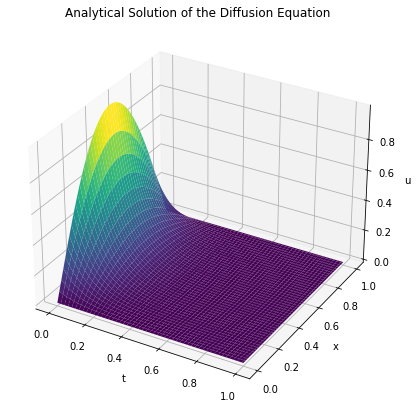

In [3]:
x = np.linspace(0, L, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(T, X, analytical_solution(X, T), cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('Analytical Solution of the Diffusion Equation')
plt.show()

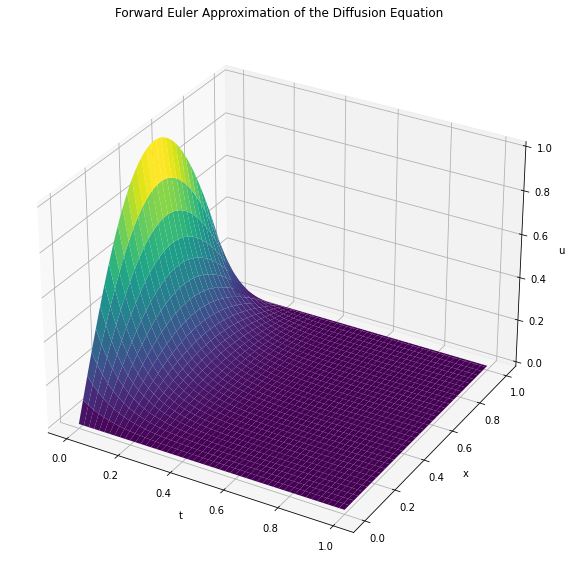

In [4]:
u = solve_diffusion_equation_FE(0.00001, 0.01, 1, plot=True)

Qualitatively similar to the FE approximation. Quantitatively, we can examine the absolute error:

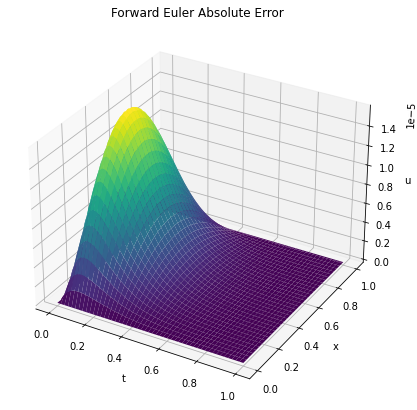

Maximum absolute error:  1.578255675016571e-05
MSE:  2.3080079455806984e-11


In [5]:
x = np.linspace(0, L, 101)
t = np.linspace(0, 1, 100000)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
absolute_error = np.absolute(
    analytical_solution(X, T) 
    - solve_diffusion_equation_FE(0.00001, 0.01, 1, plot=False)
    )
ax.plot_surface(T, X, absolute_error, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('Forward Euler Absolute Error')
plt.show()
print("Maximum absolute error: ", np.max(absolute_error))
print("MSE: ", np.mean(absolute_error**2))

We see quite low errors, however this is with a relatively small time step.

## Neural Network

Next, we will examine the performance of the PINN based approach.

In [6]:
dt = 0.1
dx = 0.1
T = 1
L = 1

In [7]:
t = np.linspace(0, T, int(T/dt) + 1)
x = np.linspace(0, L, int(L/dx) + 1)
xx, tt = np.meshgrid(x, t)
grid_shape = xx.shape
xx = xx.flatten()
tt = tt.flatten()
xt = np.vstack((xx, tt)).T

In [36]:
hidden_layers = [128, 128, 128]
model = PDESolver(
    hidden_layers=hidden_layers,
    regularization=0.0001,
    problem="diffusion",
    activation_function="tanh"
    )
from time import time
start = time()
model.fit(xt, epochs=1000)
end = time()
print("Training time: ", end - start)

Epoch 1/1000
4/4 [==============================] - 2s 4ms/step - loss: 11.3762
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.8225
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.5742
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.4945
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.1639
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.8667
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.5795
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.1201
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.5706
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 7.8390
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 7.1669
Epoch 12/1000
4/4 [==============================] - 0s 5ms/step - loss: 6.3273
Epoch 13/1000
4/4 [=========================

In [46]:
def grid_search(xt, lambdas, etas, n_averages, hidden_layers, epochs):
    print(".", end="")
    min_loss = 1e10
    best_eta = -1
    best_lmbda = -1
    for eta in etas:
        for lmbda in lambdas:
            total_loss = 0
            for i in range(n_averages):
                model = PDESolver(
                hidden_layers=hidden_layers,
                learning_rate=eta,
                regularization=lmbda,
                problem="diffusion",
                activation_function="tanh"
                )
                model.fit(xt, epochs=epochs, verbose=0)
                total_loss += model.get_cost(xt)
            average_loss = total_loss / n_averages
            if average_loss < min_loss:
                min_loss = average_loss
                best_eta = eta
                best_lmbda = lmbda
            print(" .", end="")
    print(" Done!")
    return best_eta, best_lmbda, min_loss


lambdas = [0, 1e-7, 1e-6, 1e-5]
etas = [1e-5, 1e-4, 1e-3, 1e-2]
n_averages = 20
epochs = 1000

best_eta, best_lmbda, min_loss = grid_search(xt, lambdas, etas, n_averages, hidden_layers, epochs)
print(best_eta, best_lmbda, min_loss)


.

0.001 0 0.001606806879863143


In [39]:
print(model.get_cost(xt))


0.0026347016


0.0021325557


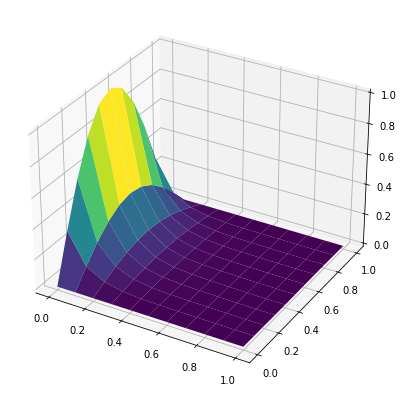

In [15]:
N = model(xt)

xx = xx.reshape(grid_shape)
tt = tt.reshape(grid_shape)
N = N.reshape(grid_shape)
u = u_trial(xx, tt, N)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(tt, xx, u, cmap='viridis')
plt.show()

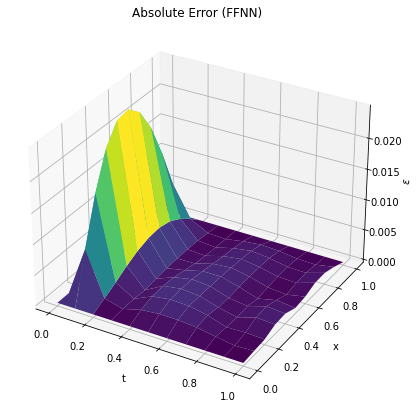

MSE: 2.711450322914935e-05
Max absolute error: 0.02474059565885789


In [11]:
# Compute the absolute error
absolute_error = np.absolute(
    u_analytical(xx, tt) - u
    )

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute Error (FFNN)')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$\epsilon$')
ax.plot_surface(tt, xx, absolute_error, cmap='viridis')
plt.show()

print("MSE:", np.mean(absolute_error**2))
print("Max absolute error:", np.max(absolute_error))


Compare with FE on same discretization.

In [12]:
FE_absolute_error = np.absolute(
    analytical_solution(xx, tt) 
    - solve_diffusion_equation_FE(dt, dx, 1, plot=False)
    )
print("FE MSE:", np.mean(FE_absolute_error**2))
print("FE Max absolute error:", np.max(FE_absolute_error))

FE MSE: 0.006138909952070619
FE Max absolute error: 0.351577512950366


In [13]:
nn = NeuralNetwork([2, 20, 20, 20, 1], cost_function="diffusion")
x = np.linspace(0, L, int(L/dx) + 1)
t = np.linspace(0, T, int(T/dt) + 1)
xx, tt = np.meshgrid(x, t)
# save shape of X and T
xt_shape = xx.shape

xx = xx.flatten()
tt = tt.flatten()
X = np.array([xx, tt]).T
y = np.zeros(X.shape[0])
wb = nn.wb()

start = time()
print("Initial weights and biases: ", wb.shape)
print("Initial cost: ", nn.cost(wb, X, y))
print("Initial gradient: ", nn.gradient(wb, X, y))
print("Time taken: ", time() - start)


# Run gradient descent
from gradient_descent import GradientDescent
import matplotlib.pyplot as plt
gd = GradientDescent(store_extra=True)
wb = gd.train(X, wb, X[:, 0], nn, 0.1, 100)
plt.plot(gd.costs)
plt.show()

# Compute solution at all points using diffusion_trial
sol = np.zeros((X.shape[0]))
for i in range(X.shape[0]):
    sol[i] = nn.diffusion_trial(X[i], wb)

# Reshape solution to original shape
sol = sol.reshape(xt_shape)

NameError: name 'NeuralNetwork' is not defined

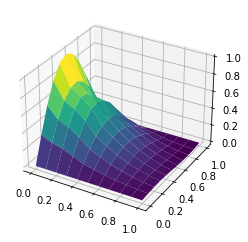

In [ ]:
# Create 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(tt.reshape(xt_shape), xx.reshape(xt_shape), sol, cmap='viridis')
plt.show()

Next, we want to compare this solution to the analytical solution. We can do this by computing the absolute error at each point in the domain.

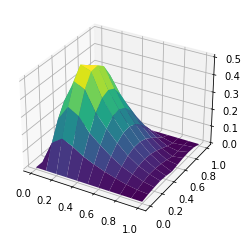

In [ ]:
#absolute error:
absolute_error = np.absolute(
    analytical_solution(xx.reshape(xt_shape), tt.reshape(xt_shape))
    - sol
    )

# Create 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(tt.reshape(xt_shape), xx.reshape(xt_shape), absolute_error, cmap='viridis')
plt.show()